In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import resource
import numpy as np
from skimage import img_as_bool, io, color
import tensorflow as tf
from functions import appendImgs, loadData
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.regularizers import l2
import tensorflow as tf

print('version de tensorflow')
print(tf.__version__)

os.environ["CUDA_VISIBLE_DEVICES"]="3"

DATA_DIR = "../fibergen/data"
TRAIN_DIR = "train"
VAL_DIR = "validation"
categories = ['thick', 'thin']

trainPath = os.path.join(DATA_DIR, TRAIN_DIR)
X_train, y_train = loadData(trainPath, categories)

valPath = os.path.join(DATA_DIR, VAL_DIR)
X_val, y_val = loadData(valPath, categories)

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)

print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)

Using TensorFlow backend.


version de tensorflow
2.0.0


/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:131: UserWarning: Possible sign loss when converting negative image of type float64 to positive image of type bool.
  .format(dtypeobj_in, dtypeobj_out))
/home/aalejo/anaconda3/envs/iaenv/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to bool
  .format(dtypeobj_in, dtypeobj_out))


X_train.shape =  (4000, 128, 128)
y_train.shape =  (4000,)
X_val.shape =  (800, 128, 128)
y_val.shape =  (800,)


Text(0.5, 1.0, 'Fibra delgada (1 a 3px)')

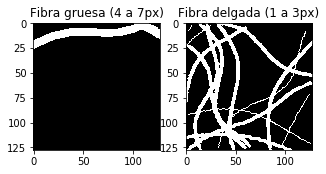

In [2]:
from random import randint
import matplotlib.pyplot as plt

total_samples = X_train.shape[0]

random_image_thick = randint(0, int(total_samples/2)-1)
random_image_thin = randint(int(total_samples/2),total_samples)

fig, axs = plt.subplots(1, 2, figsize=(5,5))

axs[0].imshow(X_train[random_image_thick],cmap='gray')
axs[0].set_title("Fibra gruesa (4 a 7px)")
axs[1].imshow(X_train[random_image_thin],cmap='gray')
axs[1].set_title("Fibra delgada (1 a 3px)")


In [4]:
from keras.layers import Input, Dense, Add
from keras.models import Model

input1 = Input(shape=(16,))
x1 = Dense(8, activation='relu')(input1)
input2 = Input(shape=(32,))
x2 = Dense(8, activation='relu')(input2)

added = Add()([x1, x2])

out = Dense(4)(added)
model = Model(inputs=[input1, input2], outputs=out)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 8)            136         input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 8)            264         input_4[0][0]                    
____________________________________________________________________________________________

AttributeError: 'Node' object has no attribute 'output_masks'

In [22]:
tf.keras.backend.clear_session()

REGU_L2 = 0.01

X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 1)

input_shape = (128, 128, 1)
#print('X_train.shape:', X_train.shape)

model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), activation='relu', use_bias=False, kernel_regularizer=l2(l=REGU_L2), input_shape=input_shape))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Conv2D(64, (5, 5), activation='relu',use_bias=False,kernel_regularizer=l2(l=REGU_L2)))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(AveragePooling2D(pool_size=(4, 4)))

#model.add(Conv2D(64, (5, 5), activation='relu',use_bias=False,kernel_regularizer=l2(l=REGU_L2)))
#model.add(BatchNormalization())
#model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Dropout(0.25))

model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation='relu',kernel_regularizer=l2(l=REGU_L2)))

model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid',kernel_regularizer=l2(l=REGU_L2)))


#optimizer = Adam(lr=0.001,decay=0.0)
optimizer = SGD(lr=0.001,momentum=0.9)

model.compile(optimizer=optimizer,
              #loss='sparse_categorical_crossentropy', 
              loss='binary_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 32)      800       
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
average_pooling2d_1 (Average (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        51200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 64)        256       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)         

In [23]:
BATCH_SIZE = 1
EPOCHS = 15

log = model.fit(x=X_train,y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), verbose=1)

Train on 4000 samples, validate on 800 samples
Epoch 1/15
4000/4000 [==============================] - 36s 9ms/step - loss: 2.1046 - acc: 0.8190 - val_loss: 3.2958 - val_acc: 0.2887
Epoch 2/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.6515 - acc: 0.9678 - val_loss: 3.3153 - val_acc: 0.4613
Epoch 3/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.3709 - acc: 0.9668 - val_loss: 1.9739 - val_acc: 0.3850
Epoch 4/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.2997 - acc: 0.9818 - val_loss: 1.5894 - val_acc: 0.4787
Epoch 5/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.3154 - acc: 0.9620 - val_loss: 1.5699 - val_acc: 0.5025
Epoch 6/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.3150 - acc: 0.9735 - val_loss: 5.0293 - val_acc: 0.3487
Epoch 7/15
4000/4000 [==============================] - 36s 9ms/step - loss: 0.2488 - acc: 0.9830 - val_loss: 2.7414 - val_acc: 0.3938
Epoch 8/

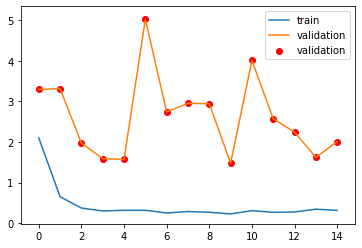

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='validation')
plt.scatter(range(0,len(log.history['val_loss'])), log.history['val_loss'], label='validation', color='red')
plt.legend()